In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Tea_leaf_disease'

Mounted at /content/drive


In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create an ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # Use 20% of data for validation
)

# Assuming your `data_dir` variable (from the previous cell) points to your image dataset
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Get the number of classes from the generator
num_classes = train_generator.num_classes
print(f"Detected {num_classes} classes.")

Found 583 images belonging to 8 classes.
Found 142 images belonging to 8 classes.
Detected 8 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add a custom classification head on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) # Add a dense layer
predictions = Dense(num_classes, activation='softmax')(x) # Output layer for classification

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,577,928 (13.65 MB)

 Trainable params: 1,319,944 (5.04 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
# It's recommended to train for more epochs, this is just an example
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("Model training complete!")

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 215s 12s/step - accuracy: 0.2442 - loss: 2.0114 - val_accuracy: 0.4375 - val_loss: 1.6214
Epoch 2/25
 1/18 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5000 - loss: 1.4682

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5000 - loss: 1.4682 - val_accuracy: 0.4219 - val_loss: 1.5588
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.5446 - loss: 1.3437 - val_accuracy: 0.5312 - val_loss: 1.2492
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 796ms/step - accuracy: 0.6875 - loss: 1.1125 - val_accuracy: 0.6094 - val_loss: 1.1715
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.6541 - loss: 1.0103 - val_accuracy: 0.5938 - val_loss: 1.0774
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 727ms/step - accuracy: 0.7500 - loss: 0.7697 - val_accuracy: 0.5781 - val_loss: 1.1221
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.7655 - loss: 0.7693 - val_accuracy: 0.6328 - val_loss: 1.0632
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 755ms/step - accuracy: 0.8438 - loss: 0.6095 - val_accuracy: 0.5859 - val_loss: 1.0939
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.7867 - loss: 0.6669 - val_accuracy: 0.6484 - val_loss: 

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os
from google.colab import files

# Prompt user to upload an image file
uploaded = files.upload()

# Get the filename of the uploaded file
if uploaded:
    for fn in uploaded.keys():
        local_image_path = fn
        print(f"User uploaded file: {local_image_path}")

    # Load and preprocess the image
    img = image.load_img(local_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Create a batch dimension
    img_array = img_array / 255.0 # Rescale the image like the training data

    # Make a prediction
    predictions = model.predict(img_array)

    print(f"Raw prediction probabilities: {predictions}")

    # Interpret the prediction
    class_names = list(train_generator.class_indices.keys())
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    print(f"Predicted class: {predicted_class_name} with {confidence:.2f}% confidence.")

    if num_classes == 1:
        print("\nReminder: The model was trained with data from a directory that contained only one effective class.")
        print("If you intended multiple classes, please ensure your dataset is organized into separate subdirectories for each class.")
else:
    print("No file was uploaded.")

Saving UNADJUSTEDNONRAW_thumb_24a.jpg to UNADJUSTEDNONRAW_thumb_24a.jpg
User uploaded file: UNADJUSTEDNONRAW_thumb_24a.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Raw prediction probabilities: [[0.0122469  0.00820034 0.02673826 0.08961454 0.0052421  0.68827885
  0.02640089 0.1432781 ]]
Predicted class: healthy with 68.83% confidence.


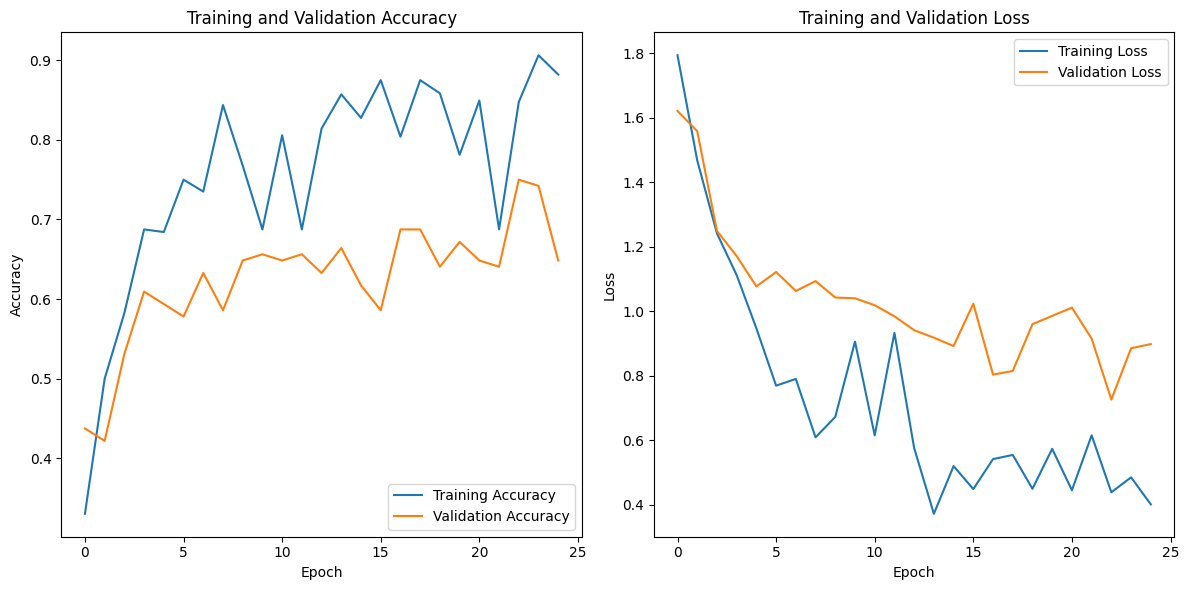

----------------------------------------------------
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


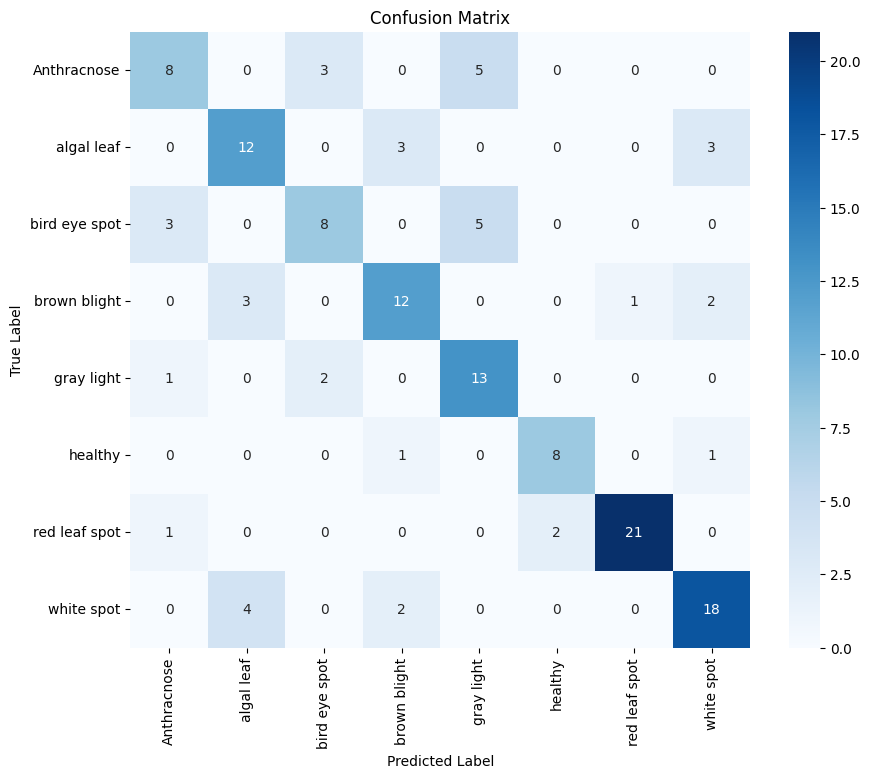

Evaluation complete!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Plotting Training and Validation Accuracy and Loss

# Get the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

print("----------------------------------------------------")

# 2. Generating Confusion Matrix

# Reset the validation generator to ensure correct order of samples
validation_generator.reset()

# Get true labels for the validation set
y_true = validation_generator.classes[validation_generator.index_array]

# Get predictions from the model on the validation data
# Note: validation_steps was used in model.fit, so ensure we predict on the same number of steps

# Calculate steps for prediction to cover all validation samples
num_val_samples = validation_generator.samples
val_steps = int(np.ceil(num_val_samples / BATCH_SIZE)) # Cast to int

y_pred_raw = model.predict(validation_generator, steps=val_steps, verbose=1)

# Get the predicted class indices
y_pred = np.argmax(y_pred_raw, axis=1)

# Get class names from the generator
class_labels = list(validation_generator.class_indices.keys())

# Ensure y_true and y_pred have the same length
# The generator might yield more batches than strictly needed, or fewer if not enough data.
# We should trim y_true and y_pred to match the actual number of samples processed.

# The number of samples successfully predicted will be len(y_pred)
# So, we should trim y_true to match this length.
if len(y_true) > len(y_pred):
    y_true = y_true[:len(y_pred)]
elif len(y_pred) > len(y_true):
    # This case should ideally not happen if val_steps is calculated correctly
    # but as a safeguard, we trim y_pred.
    y_pred = y_pred[:len(y_true)]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("Evaluation complete!")